# Machine Learning Models - Case Técnico Ifood
---
Este notebook desenvolve modelos de machine learning para o programa de cupons do iFood,
usando apenas funcionalidades disponíveis no Databricks Community Edition.

## 1. Importação de Bibliotecas

In [0]:

from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, count, avg, sum as spark_sum, max as spark_max, min as spark_min
from pyspark.sql.types import *
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## 2. Carregamento dos Dados

In [0]:
try:
    df_unified = spark.table("default.unified_data")
    print(f"Dados carregados: {df_unified.count():,} registros")
    print("\nSchema dos dados:")
    df_unified.printSchema()
    
except Exception as e:
    print(f"Erro ao carregar dados: {e}")

Dados carregados: 272,388 registros

Schema dos dados:
root
 |-- customer_id: string (nullable = true)
 |-- customer_age: long (nullable = true)
 |-- customer_gender: string (nullable = true)
 |-- credit_card_limit: double (nullable = true)
 |-- registration_date: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- days_since_start: double (nullable = true)
 |-- transaction_amount: double (nullable = true)
 |-- reward_amount: double (nullable = true)
 |-- offer_id: string (nullable = true)
 |-- offer_type: string (nullable = true)
 |-- min_spend_required: long (nullable = true)
 |-- offer_duration_days: double (nullable = true)
 |-- offer_discount_value: long (nullable = true)
 |-- offer_channels: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- event_category_pt: string (nullable = true)
 |-- offer_type_pt: string (nullable = true)
 |-- age_segment: string (nullable = true)
 |-- credit_segment: string (nullable = true)



In [0]:
# Ler a tabela Spark
df = spark.table("default.unified_data")

# Caminho permitido no DBFS do usuário
output_path = "dbfs:/user/lucas.mirachi@gmail.com/ifood-case/unified_data.json"

# Salvar como JSON
df.coalesce(1).write.mode("overwrite").json(output_path)

print(f"JSON salvo em: {output_path}")


---------------------------------------------------------------------------
UnsupportedOperationException             Traceback (most recent call last)
File <command-8631545313430537>, line 8
      5 output_path = "dbfs:/user/lucas.mirachi@gmail.com/ifood-case/unified_data.json"
      7 # Salvar como JSON
----> 8 df.coalesce(1).write.mode("overwrite").json(output_path)
     10 print(f"JSON salvo em: {output_path}")

File /databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/readwriter.py:740, in DataFrameWriter.json(self, path, mode, compression, dateFormat, timestampFormat, lineSep, encoding, ignoreNullFields)
    731 self.mode(mode)
    732 self._set_opts(
    733     compression=compression,
    734     dateFormat=dateFormat,
   (...)
    738     ignoreNullFields=ignoreNullFields,
    739 )
--> 740 self.format("json").save(path)

File /databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/readwriter.py:679, in DataFrameWriter.save(self, path, format, mode,

## 3. Preparação dos Dados para ML

In [0]:
# criando um dataframe com as features agregadas por cliente
customer_features = df_unified.groupBy("customer_id").agg(
    # features comportamentais
    count("*").alias("total_interactions"),
    F.countDistinct("event_type").alias("event_types_count"),
    
    # features de engajamento com ofertas
    F.sum(when(col("event_type") == "offer received", 1).otherwise(0)).alias("offers_received"),
    F.sum(when(col("event_type") == "offer viewed", 1).otherwise(0)).alias("offers_viewed"),
    F.sum(when(col("event_type") == "offer completed", 1).otherwise(0)).alias("offers_completed"),
    
    # features transacionais
    F.sum(when(col("event_type") == "transaction", 1).otherwise(0)).alias("total_transactions"),
    avg(when(col("transaction_amount").isNotNull(), col("transaction_amount"))).alias("avg_transaction_amount"),
    spark_sum(when(col("transaction_amount").isNotNull(), col("transaction_amount")).otherwise(0)).alias("total_spent"),
    
    # features temporais
    spark_min("days_since_start").alias("first_interaction_day"),
    spark_max("days_since_start").alias("last_interaction_day"),
    
    # features demográficas
    F.first("customer_age").alias("age"),
    F.first("customer_gender").alias("gender"),
    F.first("credit_card_limit").alias("credit_limit"),
    F.first("age_segment").alias("age_segment"),
    F.first("credit_segment").alias("credit_segment")
).fillna(0)


customer_features = customer_features.withColumn(
    "activity_span", 
    col("last_interaction_day") - col("first_interaction_day") + 1
).withColumn(
    "interaction_frequency", 
    col("total_interactions") / col("activity_span")
).withColumn(
    "offer_view_rate",
    when(col("offers_received") > 0, col("offers_viewed") / col("offers_received")).otherwise(0)
).withColumn(
    "offer_completion_rate",
    when(col("offers_received") > 0, col("offers_completed") / col("offers_received")).otherwise(0)
).withColumn(
    "avg_daily_spending",
    col("total_spent") / col("activity_span")
)

# limpando dados nulos
customer_features_clean = customer_features.filter(
    col("age").isNotNull() & 
    col("gender").isNotNull() & 
    col("credit_limit").isNotNull()
).fillna(0)

print(f"Features criadas para {customer_features_clean.count():,} clientes únicos")

# Converter para Pandas para uso com scikit-learn
pdf_features = customer_features_clean.toPandas()
print(f"Shape dos dados: {pdf_features.shape}")

Features criadas para 14,825 clientes únicos
Shape dos dados: (14825, 21)


## 4. Classificação - Previsão de Conversão

In [0]:
pdf_features['converted'] = (pdf_features['offers_completed'] > 0).astype(int)

# filtrando apenas clientes que receberam ofertas
classification_data = pdf_features[pdf_features['offers_received'] > 0].copy()

# features para o modelo
feature_columns = [
    'age', 'credit_limit', 'total_interactions', 'avg_transaction_amount',
    'total_spent', 'interaction_frequency', 'offer_view_rate', 'activity_span'
]

categorical_features = ['gender', 'age_segment', 'credit_segment']

print(f"Dataset para classificação: {len(classification_data):,} registros")
print(f"Features numéricas: {len(feature_columns)}")
print(f"Features categóricas: {len(categorical_features)}")

# Preparar X e y
X_num = classification_data[feature_columns].fillna(0)
X_cat = classification_data[categorical_features].fillna('unknown')
y = classification_data['converted']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    pd.concat([X_num, X_cat], axis=1), y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dados de treino: {len(X_train_cat):,}")
print(f"Dados de teste: {len(X_test_cat):,}")

Dataset para classificação: 14,820 registros
Features numéricas: 8
Features categóricas: 3
Dados de treino: 11,856
Dados de teste: 2,964


Aqui, tentarei testar para a tarefa de classificação, os modelos de `Regressão Logística` e `Random Forest` para depois conseguir utilizá-los para comparação.

In [0]:
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

classification_results = {}

for name, classifier in classifiers.items():
    print(f"\nTreinando {name}...")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    start_time = datetime.now()
    pipeline.fit(X_train_cat, y_train)
    training_time = (datetime.now() - start_time).total_seconds()
    
    y_pred = pipeline.predict(X_test_cat)
    y_pred_proba = pipeline.predict_proba(X_test_cat)[:, 1]
    accuracy = pipeline.score(X_test_cat, y_test)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    classification_results[name] = {
        'model': pipeline,
        'accuracy': accuracy,
        'auc': auc,
        'training_time': training_time,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Tempo de treino: {training_time:.2f}s")


Treinando Logistic Regression...
Accuracy: 0.9103
AUC: 0.9450
Tempo de treino: 1.53s

Treinando Random Forest...
Accuracy: 0.9109
AUC: 0.9581
Tempo de treino: 9.20s


Melhor modelo de classificação: Random Forest

Matriz de Confusão:
           Pred 0   Pred 1  
Real 0     402      165     
Real 1     99       2298    

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75       567
           1       0.93      0.96      0.95      2397

    accuracy                           0.91      2964
   macro avg       0.87      0.83      0.85      2964
weighted avg       0.91      0.91      0.91      2964



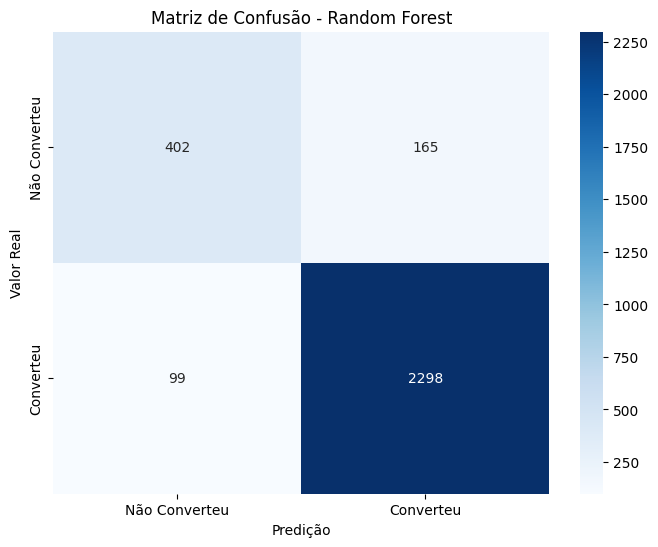

In [0]:
# Análise do melhor modelo de classificação
best_classifier = max(classification_results.keys(), key=lambda k: classification_results[k]['auc'])
print(f"Melhor modelo de classificação: {best_classifier}")

best_results = classification_results[best_classifier]

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, best_results['y_pred'])
print(f"{'':>10} {'Pred 0':<8} {'Pred 1':<8}")
print(f"{'Real 0':<10} {cm[0,0]:<8} {cm[0,1]:<8}")
print(f"{'Real 1':<10} {cm[1,0]:<8} {cm[1,1]:<8}")

print("\nRelatório de Classificação:")
print(classification_report(y_test, best_results['y_pred']))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não Converteu', 'Converteu'],
            yticklabels=['Não Converteu', 'Converteu'])
plt.title(f'Matriz de Confusão - {best_classifier}')
plt.ylabel('Valor Real')
plt.xlabel('Predição')
plt.show()

## 5. Regressão - Previsão de Valor de Compra

In [0]:
# filtrando apenas clientes que fizeram compras
regression_data = pdf_features[pdf_features['total_spent'] > 0].copy()
print(f"Dataset para regressão: {len(regression_data):,} registros")

# Features para regressão
regression_features = [
    'age', 'credit_limit', 'total_interactions', 'offers_received',
    'offers_completed', 'total_transactions', 'interaction_frequency',
    'offer_completion_rate', 'activity_span'
]

X_reg_num = regression_data[regression_features].fillna(0)
X_reg_cat = regression_data[categorical_features].fillna('unknown')
y_reg = regression_data['total_spent']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    pd.concat([X_reg_num, X_reg_cat], axis=1), y_reg, test_size=0.2, random_state=42
)

print(f"Dados de treino: {len(X_train_reg):,}")
print(f"Dados de teste: {len(X_test_reg):,}")

Dataset para regressão: 14,492 registros
Dados de treino: 11,593
Dados de teste: 2,899


Aqui, para o problema de regressão, testarei também dois modelos: `Regressão Linear` e `Random Forest`.

In [0]:
reg_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), regression_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)
regressors = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

regression_results = {}
for name, regressor in regressors.items():
    print(f"\nTreinando {name}...")
    pipeline = Pipeline([
        ('preprocessor', reg_preprocessor),
        ('regressor', regressor)
    ])
    
    start_time = datetime.now()
    pipeline.fit(X_train_reg, y_train_reg)
    training_time = (datetime.now() - start_time).total_seconds()
    y_pred_reg = pipeline.predict(X_test_reg)
    
    r2 = r2_score(y_test_reg, y_pred_reg)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
    
    regression_results[name] = {
        'model': pipeline,
        'r2': r2,
        'rmse': rmse,
        'training_time': training_time,
        'y_pred': y_pred_reg
    }
    
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Tempo de treino: {training_time:.2f}s")


Treinando Linear Regression...
R²: 0.3659
RMSE: 109.0389
Tempo de treino: 0.04s

Treinando Random Forest...
R²: 0.3748
RMSE: 108.2669
Tempo de treino: 7.01s


Melhor modelo de regressão: Random Forest


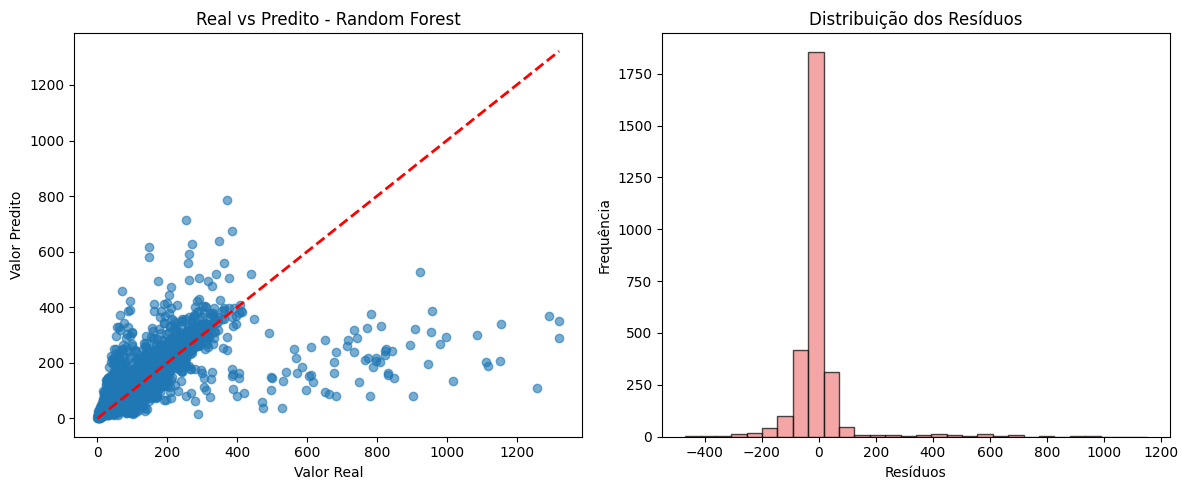

R² Score: 0.3748
RMSE: 108.2669


In [0]:
# Análise do melhor modelo de regressão
best_regressor = max(regression_results.keys(), key=lambda k: regression_results[k]['r2'])
print(f"Melhor modelo de regressão: {best_regressor}")
best_reg_results = regression_results[best_regressor]
plt.figure(figsize=(12, 5))

# gráfico Real vs Predito
plt.subplot(1, 2, 1)
plt.scatter(y_test_reg, best_reg_results['y_pred'], alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Valor Predito')
plt.title(f'Real vs Predito - {best_regressor}')

# histograma dos resíduos
plt.subplot(1, 2, 2)
residuals = y_test_reg - best_reg_results['y_pred']
plt.hist(residuals, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos')

plt.tight_layout()
plt.show()

print(f"R² Score: {best_reg_results['r2']:.4f}")
print(f"RMSE: {best_reg_results['rmse']:.4f}")

## 6. Clustering - Segmentação de Clientes

In [0]:
#  features para clustering
clustering_features = [
    'age', 'credit_limit', 'total_interactions', 'total_spent',
    'interaction_frequency', 'offer_completion_rate', 'avg_daily_spending'
]

clustering_data = pdf_features[clustering_features].fillna(0)
# normalizando os dados
scaler = StandardScaler()
clustering_scaled = scaler.fit_transform(clustering_data)

print(f"Dados para clustering: {clustering_scaled.shape}")

Dados para clustering: (14825, 7)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffa933805080>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

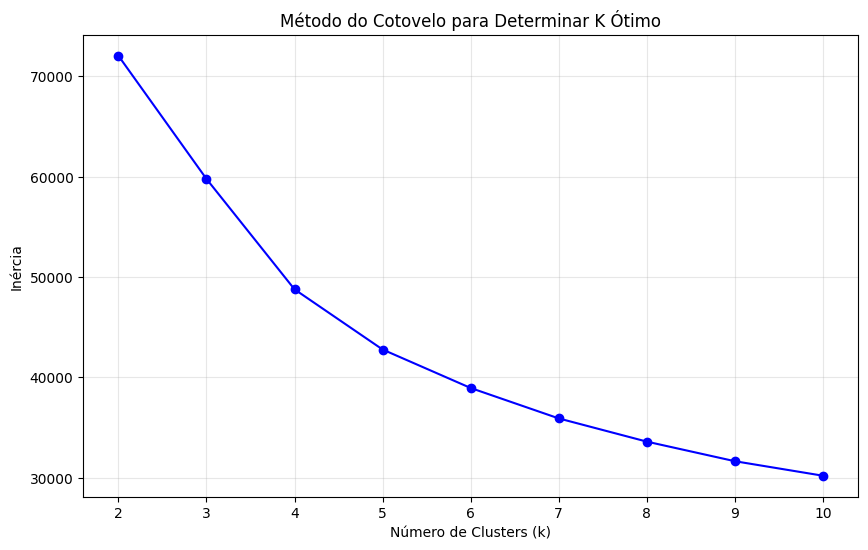

In [0]:
# determinando número ótimo de clusters usando método do cotovelo
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clustering_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.title('Método do Cotovelo para Determinar K Ótimo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.grid(True, alpha=0.3)
plt.show()

Observando o gráfico, inicialmente decidi por treinar modelo com k=4

In [0]:
optimal_k = 4
print(f"\nTreinando modelo final com k={optimal_k}")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(clustering_scaled)

# adicionando labels aos dados originais
pdf_features['cluster'] = cluster_labels

print("Distribuição dos clusters:")
print(pdf_features['cluster'].value_counts().sort_index())

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffa938fcf6a0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'



Treinando modelo final com k=4


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffa92f2e11c0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

Distribuição dos clusters:
0    4398
1    5651
2     283
3    4493
Name: cluster, dtype: int64


Perfil dos clusters:
           age  credit_limit  ...  avg_daily_spending  converted
cluster                       ...                               
0        48.83      55244.66  ...                5.60       0.99
1        50.75      55923.91  ...                1.24       0.51
2        56.86      76402.83  ...               29.75       0.98
3        64.27      86582.46  ...                5.62       1.00

[4 rows x 8 columns]


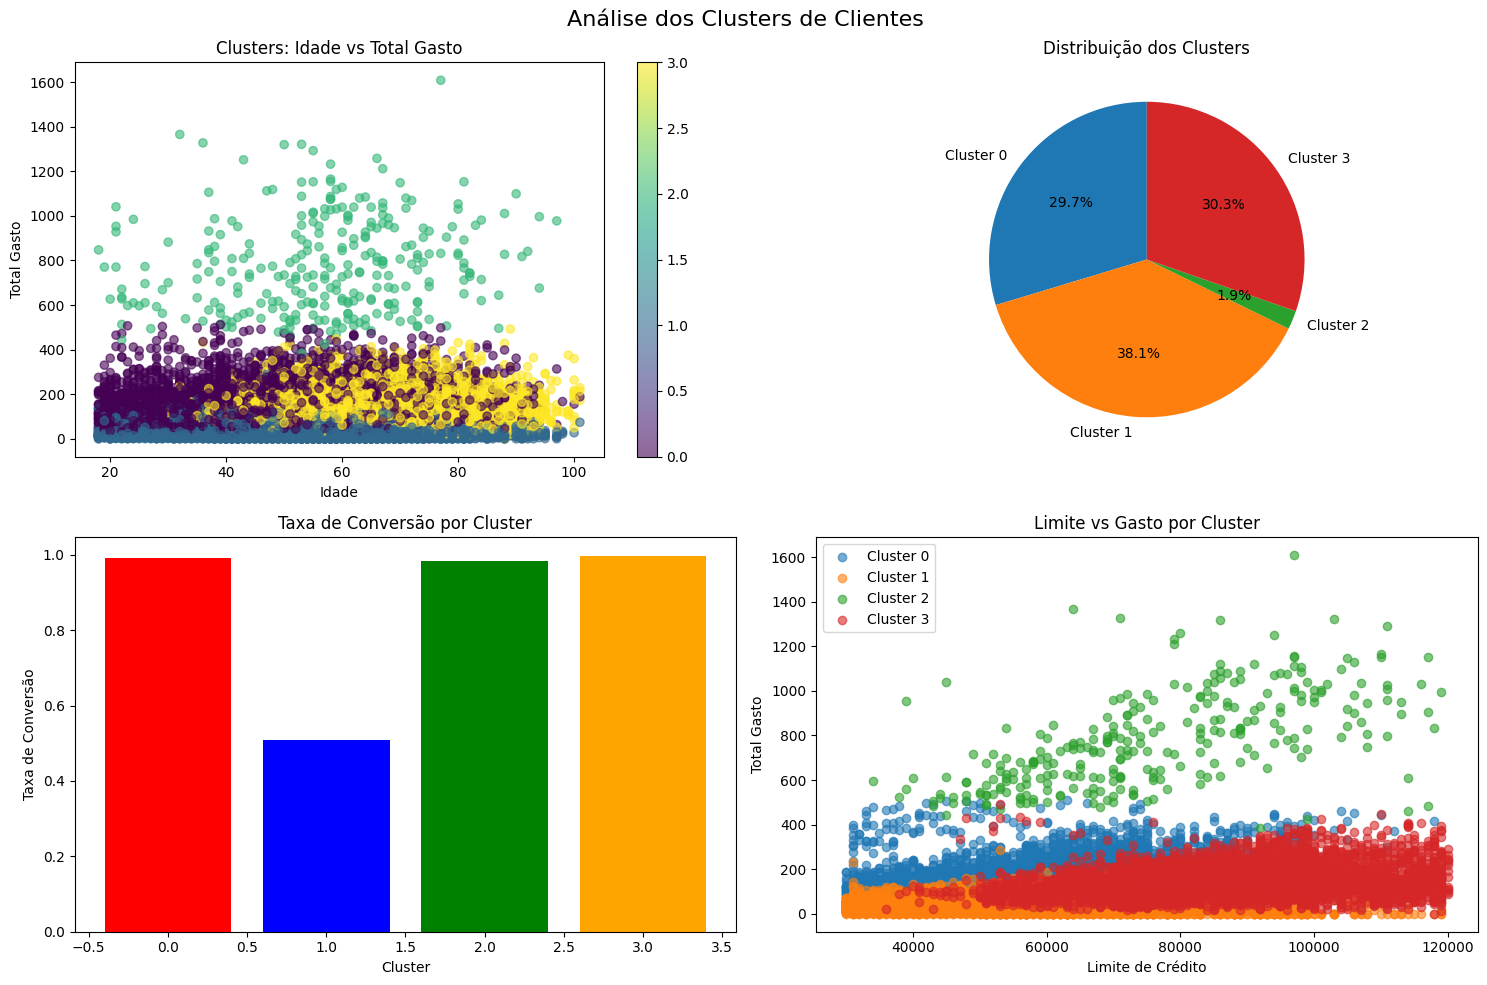

In [0]:
# estatísticas por cluster
cluster_analysis = pdf_features.groupby('cluster')[clustering_features + ['converted']].agg({
    'age': 'mean',
    'credit_limit': 'mean',
    'total_interactions': 'mean',
    'total_spent': 'mean',
    'interaction_frequency': 'mean',
    'offer_completion_rate': 'mean',
    'avg_daily_spending': 'mean',
    'converted': 'mean'
}).round(2)

print("Perfil dos clusters:")
print(cluster_analysis)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análise dos Clusters de Clientes', fontsize=16)

# 1. Gasto total vs Idade
scatter = axes[0,0].scatter(pdf_features['age'], pdf_features['total_spent'], 
                           c=pdf_features['cluster'], cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('Idade')
axes[0,0].set_ylabel('Total Gasto')
axes[0,0].set_title('Clusters: Idade vs Total Gasto')
plt.colorbar(scatter, ax=axes[0,0])

# 2. Distribuição dos clusters
cluster_counts = pdf_features['cluster'].value_counts().sort_index()
axes[0,1].pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index], 
              autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Distribuição dos Clusters')

# 3. Taxa de conversão por cluster
conversion_by_cluster = pdf_features.groupby('cluster')['converted'].mean()
axes[1,0].bar(conversion_by_cluster.index, conversion_by_cluster.values, 
              color=['red', 'blue', 'green', 'orange'])
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Taxa de Conversão')
axes[1,0].set_title('Taxa de Conversão por Cluster')

# 4. Limite de crédito vs Total gasto por cluster
for cluster in range(optimal_k):
    cluster_data = pdf_features[pdf_features['cluster'] == cluster]
    axes[1,1].scatter(cluster_data['credit_limit'], cluster_data['total_spent'], 
                     alpha=0.6, label=f'Cluster {cluster}')
axes[1,1].set_xlabel('Limite de Crédito')
axes[1,1].set_ylabel('Total Gasto')
axes[1,1].set_title('Limite vs Gasto por Cluster')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [0]:
for cluster_id in range(optimal_k):
    cluster_data = cluster_analysis.loc[cluster_id]
    cluster_size = (pdf_features['cluster'] == cluster_id).sum()
    
    print(f"\nCLUSTER {cluster_id} ({cluster_size:,} clientes - {cluster_size/len(pdf_features)*100:.1f}%):")
    print(f" Idade média: {cluster_data['age']:.1f} anos")
    print(f" Limite médio: ${cluster_data['credit_limit']:,.0f}")
    print(f" Gasto médio: ${cluster_data['total_spent']:.2f}")
    print(f" Interações médias: {cluster_data['total_interactions']:.1f}")
    print(f" Taxa de conversão: {cluster_data['converted']*100:.1f}%")
    
    if cluster_data['total_spent'] > 50 and cluster_data['converted'] > 0.3:
        profile = "CLIENTES DE ALTO VALOR - Foco principal para retenção"
    elif cluster_data['total_spent'] > 25 and cluster_data['converted'] > 0.2:
        profile = "CLIENTES POTENCIAIS - Oportunidade de crescimento"
    elif cluster_data['converted'] > 0.4:
        profile = "CLIENTES ENGAJADOS - Alta conversão, aumentar ticket médio"
    elif cluster_data['credit_limit'] > 80000:
        profile = "CLIENTES PREMIUM - Ofertas de alto valor"
    else:
        profile = "CLIENTES INICIANTES - Necessitam nurturing"
    
    print(f"  Perfil: {profile}")


CLUSTER 0 (4,398 clientes - 29.7%):
 Idade média: 48.8 anos
 Limite médio: $55,245
 Gasto médio: $153.21
 Interações médias: 26.0
 Taxa de conversão: 99.0%
  Perfil: CLIENTES DE ALTO VALOR - Foco principal para retenção

CLUSTER 1 (5,651 clientes - 38.1%):
 Idade média: 50.8 anos
 Limite médio: $55,924
 Gasto médio: $32.13
 Interações médias: 13.2
 Taxa de conversão: 51.0%
  Perfil: CLIENTES POTENCIAIS - Oportunidade de crescimento

CLUSTER 2 (283 clientes - 1.9%):
 Idade média: 56.9 anos
 Limite médio: $76,403
 Gasto médio: $781.41
 Interações médias: 22.4
 Taxa de conversão: 98.0%
  Perfil: CLIENTES DE ALTO VALOR - Foco principal para retenção

CLUSTER 3 (4,493 clientes - 30.3%):
 Idade média: 64.3 anos
 Limite médio: $86,582
 Gasto médio: $146.55
 Interações médias: 17.1
 Taxa de conversão: 100.0%
  Perfil: CLIENTES DE ALTO VALOR - Foco principal para retenção


## 7. Resumo dos Resultados

In [0]:
print("\nMODELOS DE CLASSIFICAÇÃO (Previsão de Conversão):")
print("-" * 60)
print(f"{'Modelo':<20} {'Accuracy':<12} {'AUC':<12} {'Tempo (s)':<12}")
print("-" * 60)
for name, results in classification_results.items():
    print(f"{name:<20} {results['accuracy']:<12.4f} {results['auc']:<12.4f} {results['training_time']:<12.2f}")

print(f"\nMelhor modelo: {best_classifier} (AUC: {classification_results[best_classifier]['auc']:.4f})")

print("\nMODELOS DE REGRESSÃO (Previsão de Valor):")
print("-" * 60)
print(f"{'Modelo':<20} {'R²':<12} {'RMSE':<12} {'Tempo (s)':<12}")
print("-" * 60)
for name, results in regression_results.items():
    print(f"{name:<20} {results['r2']:<12.4f} {results['rmse']:<12.4f} {results['training_time']:<12.2f}")

print(f"\nMelhor modelo: {best_regressor} (R²: {regression_results[best_regressor]['r2']:.4f})")

print(f"\nMODELO DE CLUSTERING:")
print(f"• Algoritmo: K-Means com k={optimal_k}")
print(f"• Total de clientes segmentados: {len(pdf_features):,}")
print(f"• Inércia final: {kmeans_final.inertia_:.2f}")


MODELOS DE CLASSIFICAÇÃO (Previsão de Conversão):
------------------------------------------------------------
Modelo               Accuracy     AUC          Tempo (s)   
------------------------------------------------------------
Logistic Regression  0.9103       0.9450       1.53        
Random Forest        0.9109       0.9581       9.20        

Melhor modelo: Random Forest (AUC: 0.9581)

MODELOS DE REGRESSÃO (Previsão de Valor):
------------------------------------------------------------
Modelo               R²           RMSE         Tempo (s)   
------------------------------------------------------------
Linear Regression    0.3659       109.0389     0.04        
Random Forest        0.3748       108.2669     7.01        

Melhor modelo: Random Forest (R²: 0.3748)

MODELO DE CLUSTERING:
• Algoritmo: K-Means com k=4
• Total de clientes segmentados: 14,825
• Inércia final: 48764.58


## 8. Funções de Predição

In [0]:
def predict_conversion_probability(customer_data):
    best_model = classification_results[best_classifier]['model']
    required_features = feature_columns + categorical_features
    customer_subset = customer_data[required_features].fillna(0)
    probabilities = best_model.predict_proba(customer_subset)[:, 1]
    return probabilities

def predict_customer_value(customer_data):
    best_model = regression_results[best_regressor]['model']
    required_features = regression_features + categorical_features
    customer_subset = customer_data[required_features].fillna(0)
    predicted_values = best_model.predict(customer_subset)
    return predicted_values

def segment_customers(customer_data):
    customer_subset = customer_data[clustering_features].fillna(0)
    customer_scaled = scaler.transform(customer_subset)
    cluster_labels = kmeans_final.predict(customer_scaled)
    return cluster_labels

In [0]:
# testando funções de predição
test_sample = pdf_features.head(5).copy()

#predição de conversão
conv_probs = predict_conversion_probability(test_sample)
print(f"Probabilidades de conversão: {conv_probs}")

# predição de valor
pred_values = predict_customer_value(test_sample)
print(f"Valores preditos: {pred_values}")

# testar segmentação
segments = segment_customers(test_sample)
print(f"Clusters atribuídos: {segments}")

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffa92f2e1e40>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


Probabilidades de conversão: [1.   0.99 1.   1.   1.  ]
Valores preditos: [131.7513  75.0457 277.0807 213.8678 183.5341]
Clusters atribuídos: [3 0 0 3 3]


## 9. Insights de Negócio

In [0]:
print("\nPRINCPAIS DESCOBERTAS:")
print("-" * 50)

overall_conversion = pdf_features['converted'].mean()
print(f"Taxa de conversão geral: {overall_conversion*100:.1f}%")
valuable_clusters = cluster_analysis.sort_values('total_spent', ascending=False)
print(f"Cluster mais valioso: Cluster {valuable_clusters.index[0]} (${valuable_clusters.iloc[0]['total_spent']:.2f} médio)")

high_converters = pdf_features[pdf_features['converted'] == 1]
low_converters = pdf_features[pdf_features['converted'] == 0]
print(f"Clientes que convertem gastam em média: ${high_converters['total_spent'].mean():.2f}")
print(f"Clientes que não convertem gastam em média: ${low_converters['total_spent'].mean():.2f}")

print(f"Diferença de idade média: {high_converters['age'].mean() - low_converters['age'].mean():.2f}")
print(f"Diferença de limite de crédito médio: ${high_converters['credit_limit'].mean() - low_converters['credit_limit'].mean():.0f}")

# Análise por gênero
gender_analysis = pdf_features.groupby('gender').agg({
    'converted': 'mean',
    'total_spent': 'mean',
    'offer_completion_rate': 'mean'
}).round(3)

print(f"\nANÁLISE POR GÊNERO:")
for gender in gender_analysis.index:
    print(f"{gender}: {gender_analysis.loc[gender, 'converted']*100:.1f}% conversão, "
          f"${gender_analysis.loc[gender, 'total_spent']:.2f} gasto médio")

# Análise por segmento etário
age_segment_analysis = pdf_features.groupby('age_segment').agg({
    'converted': 'mean',
    'total_spent': 'mean',
    'offer_view_rate': 'mean'
}).round(3)

print(f"\nANÁLISE POR SEGMENTO ETÁRIO:")
for segment in age_segment_analysis.index:
    conv_rate = age_segment_analysis.loc[segment, 'converted'] * 100
    avg_spent = age_segment_analysis.loc[segment, 'total_spent']
    view_rate = age_segment_analysis.loc[segment, 'offer_view_rate'] * 100
    print(f"• {segment}: {conv_rate:.1f}% conversão, ${avg_spent:.2f} gasto médio, {view_rate:.1f}% visualização")


PRINCPAIS DESCOBERTAS:
--------------------------------------------------
Taxa de conversão geral: 80.8%
Cluster mais valioso: Cluster 2 ($781.41 médio)
Clientes que convertem gastam em média: $139.66
Clientes que não convertem gastam em média: $21.49
Diferença de idade média: 4.40
Diferença de limite de crédito médio: $12691

ANÁLISE POR GÊNERO:
F: 88.0% conversão, $140.92 gasto médio
M: 75.6% conversão, $99.59 gasto médio
O: 84.4% conversão, $124.32 gasto médio

ANÁLISE POR SEGMENTO ETÁRIO:
• adulto: 78.7% conversão, $108.84 gasto médio, 78.3% visualização
• idoso: 83.3% conversão, $128.48 gasto médio, 75.7% visualização
• jovem: 69.5% conversão, $83.87 gasto médio, 69.6% visualização
• jovem_adulto: 72.0% conversão, $85.12 gasto médio, 69.4% visualização
• maduro: 84.4% conversão, $126.74 gasto médio, 75.7% visualização


In [0]:
# potencial de receita por melhorias
total_customers = len(pdf_features)
current_revenue = pdf_features['total_spent'].sum()

print(f"• Receita atual total: ${current_revenue:,.2f}")

# Cenário: aumentar conversão em 10%
potential_new_converters = int(total_customers * overall_conversion * 0.1)
avg_converter_value = high_converters['total_spent'].mean()
potential_revenue_increase = potential_new_converters * avg_converter_value

print(f"Potencial com +10% conversão: ${potential_revenue_increase:,.2f} (+{potential_revenue_increase/current_revenue*100:.1f}%)")

# Cenário: aumentar ticket médio em 15%
current_avg_ticket = pdf_features['total_spent'].mean()
potential_ticket_increase = current_revenue * 0.15
print(f"• Potencial com +15% ticket médio: ${potential_ticket_increase:,.2f} (+15.0%)")

• Receita atual total: $1,734,942.40
Potencial com +10% conversão: $167,308.29 (+9.6%)
• Potencial com +15% ticket médio: $260,241.36 (+15.0%)
